# SBA Loan Default Prediction - Model Training Pipeline

**Project:** SBA 7(a) Loan Credit Risk Model  
**Model Type:** Binary Classification (XGBoost)  
**Target:** `IsDefault` (0 = PIF, 1 = CHGOFF)  
**Date:** December 2025

---

## Pipeline Overview

1. **Environment Setup** - Import libraries
2. **Data Loading** - Load preprocessed X, y from CSV
3. **Train/Test Split** - Stratified split (80/20)
4. **Baseline XGBoost Model** - With class weights for imbalance
5. **Cross-Validation** - Stratified 5-fold CV
6. **Hyperparameter Tuning** - Optuna
7. **Model Evaluation** - ROC-AUC, Precision-Recall, Confusion Matrix
8. **KS Statistics & Decile Analysis** - Credit risk metrics
9. **Feature Importance** - XGB Built-in importance

---

## Class Imbalance Note

| Class | Count | Percentage |
|-------|-------|------------|
| Good Loans (0) | 51,669 | 92.55% |
| Bad Loans (1) | 4,162 | 7.45% |

**Strategy:** Use `scale_pos_weight` in XGBoost and stratified sampling throughout.

## 1. Environment Setup

In [55]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Set display options
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

print("✓ Core libraries imported successfully")

✓ Core libraries imported successfully


In [56]:
# Optional: Optuna for advanced hyperparameter tuning
# Install with: pip install optuna
try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print("✓ Optuna available for advanced tuning")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠ Optuna not installed. Install with: pip install optuna")

✓ Optuna available for advanced tuning


## 2. Data Loading

In [57]:
# Load preprocessed data
X = pd.read_csv('../data/feature/sba_loan_features.csv')
y = pd.read_csv('../data/feature/sba_loan_target.csv').squeeze()  # Convert to Series

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 0 (PIF): {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)")
print(f"  Class 1 (CHGOFF): {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)")

Features (X): (55831, 79)
Target (y): (55831,)

Target distribution:
  Class 0 (PIF): 51,669 (92.55%)
  Class 1 (CHGOFF): 4,162 (7.45%)


In [58]:
X.columns

Index(['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFY',
       'InitialInterestRate', 'RevolverStatus', 'JobsSupported',
       'TimeToDisbursementDays', 'DaysSinceApproval', 'IsCovidEra',
       'TermInYears', 'NAICSSector', 'IsCreditUnion', 'IsFranchise',
       'IsFixedRate', 'HasCollateral', 'SoldSecondaryMarket',
       'SameStateLending', 'LocationIDCount', 'Type_CORPORATION',
       'Type_INDIVIDUAL', 'Type_PARTNERSHIP', 'Age_ChangeOfOwnership',
       'Age_Existing', 'Age_NewBusiness', 'Age_Startup', 'State_AK',
       'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT',
       'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_GU', 'State_HI',
       'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
       'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
       'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'Stat

In [59]:
#dropping the features
X.drop(columns=['SoldSecondaryMarket', 'DaysSinceApproval', 'TimeToDisbursementDays', 'TermInYears'], inplace=True)

In [61]:
# Quick data check
print("Feature columns:")
print(X.columns.tolist())
print(f"\nMissing values: {X.isnull().sum().sum()}")
print(f"Data types:\n{X.dtypes.value_counts()}")

Feature columns:
['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFY', 'InitialInterestRate', 'RevolverStatus', 'JobsSupported', 'IsCovidEra', 'NAICSSector', 'IsCreditUnion', 'IsFranchise', 'IsFixedRate', 'HasCollateral', 'SameStateLending', 'LocationIDCount', 'Type_CORPORATION', 'Type_INDIVIDUAL', 'Type_PARTNERSHIP', 'Age_ChangeOfOwnership', 'Age_Existing', 'Age_NewBusiness', 'Age_Startup', 'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_GU', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_PR', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VI', 'State_VT', 'S

In [62]:
# Handle NAICSSector if it's still a string (convert to numeric)
if X['NAICSSector'].dtype == 'object':
    print("Converting NAICSSector to numeric...")
    X['NAICSSector'] = pd.to_numeric(X['NAICSSector'], errors='coerce').fillna(0).astype(int)
    print(f"NAICSSector dtype: {X['NAICSSector'].dtype}")

## 3. Train/Test Split

**Strategy:** Stratified split to maintain class distribution

In [63]:
# Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nClass distribution in training set:")
print(f"  Class 0: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Class 1: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"\nClass distribution in test set:")
print(f"  Class 0: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  Class 1: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

Training set: 44,664 samples
Test set: 11,167 samples

Class distribution in training set:
  Class 0: 41,334 (92.54%)
  Class 1: 3,330 (7.46%)

Class distribution in test set:
  Class 0: 10,335 (92.55%)
  Class 1: 832 (7.45%)


In [64]:
# Calculate scale_pos_weight for class imbalance
# Formula: negative_count / positive_count
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")
print(f"(This gives more weight to the minority class - defaults)")

scale_pos_weight for XGBoost: 12.41
(This gives more weight to the minority class - defaults)


## 4. Baseline XGBoost Model

Train a baseline model with default parameters + class weight handling

In [65]:
# Baseline XGBoost with class weights
xgb_baseline = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training baseline XGBoost model...")
xgb_baseline.fit(X_train, y_train)
print("✓ Baseline model trained")

Training baseline XGBoost model...
✓ Baseline model trained


In [66]:
# Evaluate baseline model
y_pred_baseline = xgb_baseline.predict(X_test)
y_prob_baseline = xgb_baseline.predict_proba(X_test)[:, 1]

print("="*60)
print("BASELINE XGBOOST RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_baseline):.4f}")
print(f"Average Precision (PR-AUC): {average_precision_score(y_test, y_prob_baseline):.4f}")

BASELINE XGBOOST RESULTS
Accuracy: 0.8213
Precision: 0.2432
Recall: 0.6623
F1 Score: 0.3557
ROC-AUC: 0.8358
Average Precision (PR-AUC): 0.3511


In [67]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['PIF (0)', 'CHGOFF (1)']))


Classification Report:
              precision    recall  f1-score   support

     PIF (0)       0.97      0.83      0.90     10335
  CHGOFF (1)       0.24      0.66      0.36       832

    accuracy                           0.82     11167
   macro avg       0.61      0.75      0.63     11167
weighted avg       0.91      0.82      0.86     11167



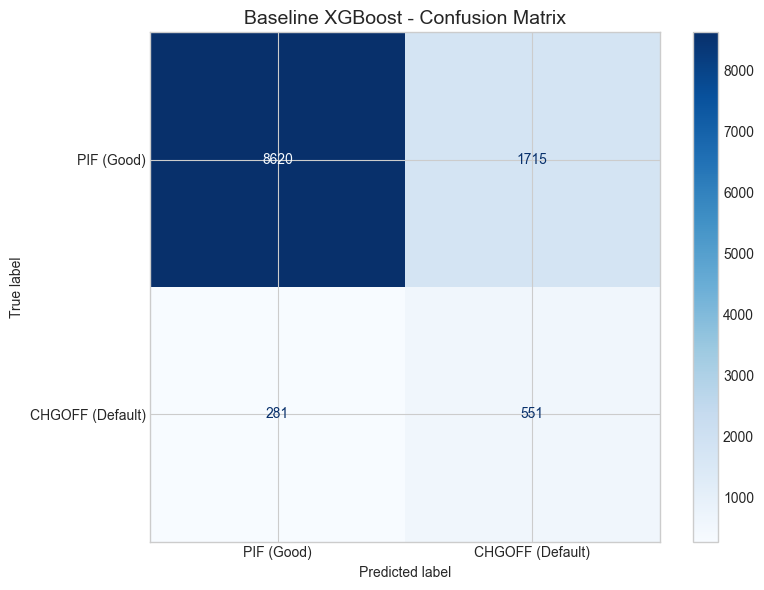

In [68]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    xgb_baseline, X_test, y_test,
    display_labels=['PIF (Good)', 'CHGOFF (Default)'],
    cmap='Blues',
    ax=ax
)
plt.title('Baseline XGBoost - Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Cross-Validation

**Strategy:** Stratified 5-fold CV for robust performance estimation

In [69]:
# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores for multiple metrics
cv_scores = {
    'accuracy': cross_val_score(xgb_baseline, X_train, y_train, cv=cv, scoring='accuracy'),
    'f1': cross_val_score(xgb_baseline, X_train, y_train, cv=cv, scoring='f1'),
    'roc_auc': cross_val_score(xgb_baseline, X_train, y_train, cv=cv, scoring='roc_auc'),
    'precision': cross_val_score(xgb_baseline, X_train, y_train, cv=cv, scoring='precision'),
    'recall': cross_val_score(xgb_baseline, X_train, y_train, cv=cv, scoring='recall')
}

print("="*60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
for metric, scores in cv_scores.items():
    print(f"{metric.upper():12s}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

5-FOLD CROSS-VALIDATION RESULTS
ACCURACY    : 0.8259 (+/- 0.0085)
F1          : 0.3506 (+/- 0.0128)
ROC_AUC     : 0.8207 (+/- 0.0070)
PRECISION   : 0.2429 (+/- 0.0101)
RECALL      : 0.6300 (+/- 0.0343)


## 6. Hyperparameter Tuning with Optuna

More thorough search using Bayesian optimization

In [70]:
# Optuna hyperparameter tuning (if available)
if OPTUNA_AVAILABLE:
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 2)
        }
        
        model = XGBClassifier(
            **params,
            objective='binary:logistic',
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        return scores.mean()
    
    # Create and run study
    print("Running Optuna optimization (50 trials)...")
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    print(f"\n✓ Optuna Complete")
    print(f"Best ROC-AUC: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
else:
    print("⚠ Optuna not available. Skipping advanced tuning.")
    print("Install with: pip install optuna")

[I 2025-12-25 16:44:30,203] A new study created in memory with name: no-name-73002b67-bad2-4caa-956e-2d317ee69f11


Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-25 16:44:32,830] Trial 0 finished with value: 0.8127304943207107 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681771, 'n_estimators': 393, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 1.2022300234864176}. Best is trial 0 with value: 0.8127304943207107.
[I 2025-12-25 16:44:37,651] Trial 1 finished with value: 0.8293438706524786 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171997, 'n_estimators': 488, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 0.6084844859190754, 'reg_lambda': 1.0495128632644757}. Best is trial 1 with value: 0.8293438706524786.
[I 2025-12-25 16:44:40,295] Trial 2 finished with value: 0.8273111876573918 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 345, 'min_child_weig

In [71]:
# Train best Optuna model (if available)
if OPTUNA_AVAILABLE:
    xgb_best = XGBClassifier(
        **study.best_params,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    xgb_best.fit(X_train, y_train)
    
    y_pred_best = xgb_best.predict(X_test)
    y_prob_best = xgb_best.predict_proba(X_test)[:, 1]
    
    print("="*60)
    print("OPTUNA BEST MODEL RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_best):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_prob_best):.4f}")
else:
    # Use baseline as best model if Optuna not available
    xgb_best = xgb_baseline
    y_pred_best = y_pred_baseline
    y_prob_best = y_prob_baseline
    print("Using baseline model as best model")

OPTUNA BEST MODEL RESULTS
Accuracy: 0.8460
Precision: 0.2767
Recall: 0.6611
F1 Score: 0.3901
ROC-AUC: 0.8463
Average Precision: 0.3708


## 7. Model Evaluation

Comprehensive evaluation of the best model

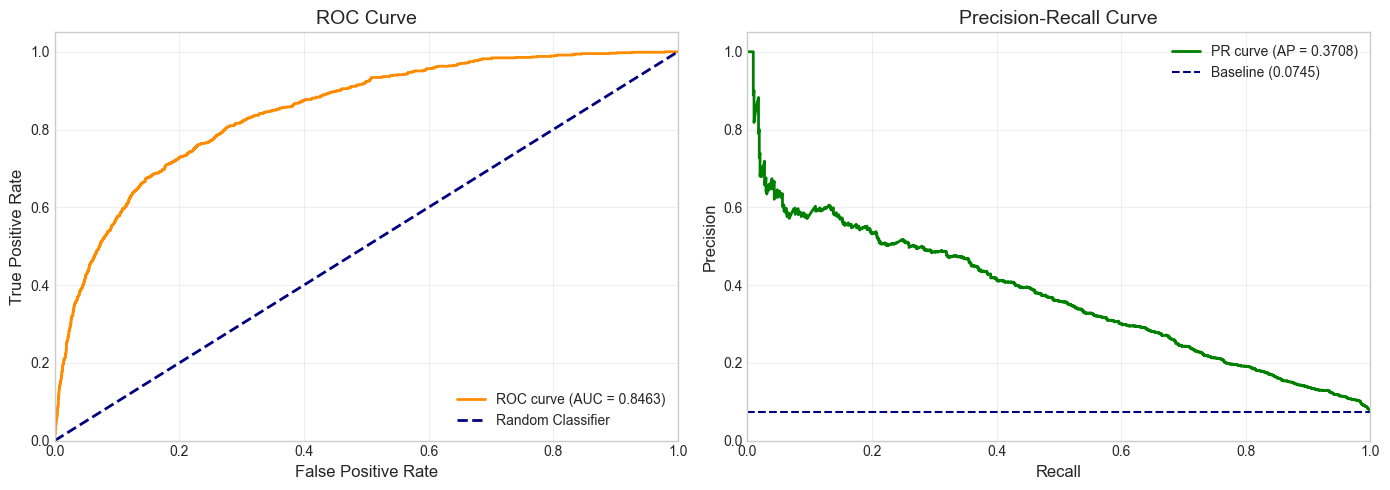

✓ Saved: model_evaluation_curves.png


In [72]:
# ROC Curve and Precision-Recall Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = roc_auc_score(y_test, y_prob_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_best)
avg_precision = average_precision_score(y_test, y_prob_best)

axes[1].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=(y_test == 1).mean(), color='navy', linestyle='--', label=f'Baseline ({(y_test == 1).mean():.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('model_evaluation_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: model_evaluation_curves.png")

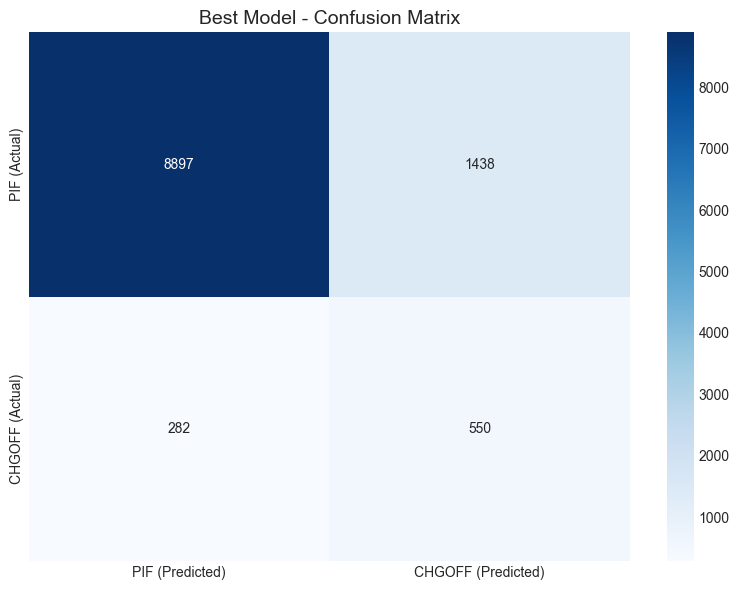

✓ Saved: confusion_matrix.png


In [ ]:
# Confusion Matrix for best model
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['PIF (Predicted)', 'CHGOFF (Predicted)'],
    yticklabels=['PIF (Actual)', 'CHGOFF (Actual)'],
    ax=ax
)
ax.set_title('Best Model - Confusion Matrix', fontsize=14)
plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: confusion_matrix.png")

## 8. KS Statistics & Decile Analysis

**KS Statistic:** Kolmogorov-Smirnov statistic measures the maximum separation between cumulative distributions of good and bad loans

**Decile Table:** Shows model performance across score deciles (bins)

In [74]:
# Calculate KS Statistic
def calculate_ks_statistic(y_true, y_prob):
    """
    Calculate KS statistic
    """
    # Create DataFrame with actuals and probabilities
    df_ks = pd.DataFrame({
        'actual': y_true,
        'prob': y_prob
    }).sort_values('prob', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative percentages
    df_ks['bad'] = df_ks['actual']
    df_ks['good'] = 1 - df_ks['actual']
    
    df_ks['cum_bad'] = df_ks['bad'].cumsum() / df_ks['bad'].sum()
    df_ks['cum_good'] = df_ks['good'].cumsum() / df_ks['good'].sum()
    
    # KS is the maximum difference
    df_ks['ks'] = np.abs(df_ks['cum_bad'] - df_ks['cum_good'])
    
    ks_stat = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    
    return ks_stat, ks_index, df_ks

# Calculate KS
ks_stat, ks_index, df_ks = calculate_ks_statistic(y_test.values, y_prob_best)

print("="*60)
print("KS STATISTIC")
print("="*60)
print(f"KS Statistic: {ks_stat:.4f}")
print(f"KS occurs at probability: {df_ks.loc[ks_index, 'prob']:.4f}")
print(f"")
print("Interpretation:")
if ks_stat > 0.4:
    print("  Excellent discrimination (KS > 0.4)")
elif ks_stat > 0.3:
    print("  Good discrimination (KS > 0.3)")
elif ks_stat > 0.2:
    print("  Acceptable discrimination (KS > 0.2)")
else:
    print("  Poor discrimination (KS < 0.2)")

KS STATISTIC
KS Statistic: 0.5311
KS occurs at probability: 0.3767

Interpretation:
  Excellent discrimination (KS > 0.4)


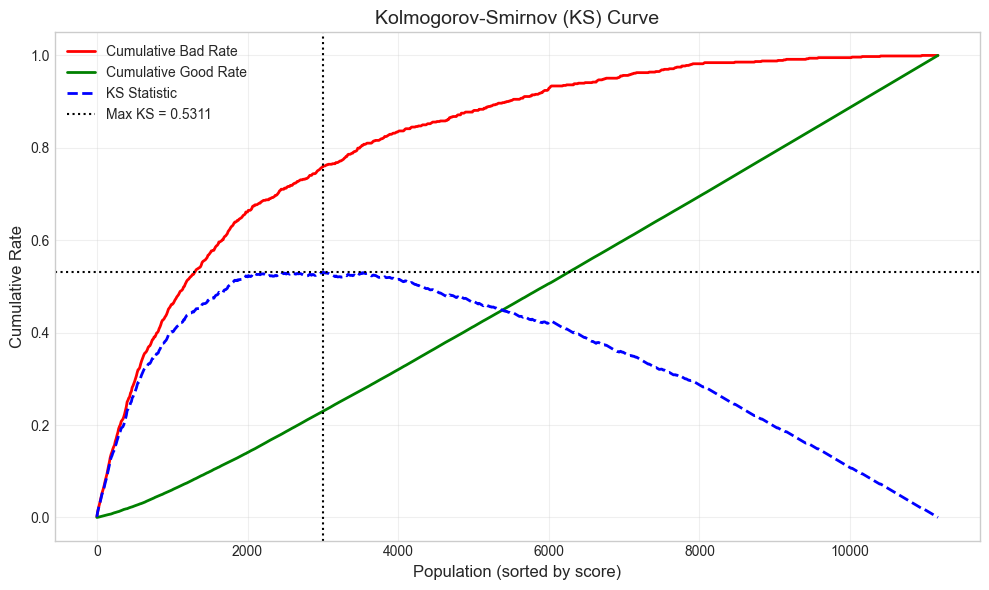

✓ Saved: ks_curve.png


In [75]:
# Plot KS Curve
fig, ax = plt.subplots(figsize=(10, 6))

# Sample points for plotting (to avoid too many points)
sample_size = min(1000, len(df_ks))
sample_indices = np.linspace(0, len(df_ks)-1, sample_size, dtype=int)
df_plot = df_ks.iloc[sample_indices]

ax.plot(df_plot.index, df_plot['cum_bad'], label='Cumulative Bad Rate', color='red', lw=2)
ax.plot(df_plot.index, df_plot['cum_good'], label='Cumulative Good Rate', color='green', lw=2)
ax.plot(df_plot.index, df_plot['ks'], label='KS Statistic', color='blue', lw=2, linestyle='--')

# Mark maximum KS
ax.axvline(x=ks_index, color='black', linestyle=':', lw=1.5, label=f'Max KS = {ks_stat:.4f}')
ax.axhline(y=ks_stat, color='black', linestyle=':', lw=1.5)

ax.set_xlabel('Population (sorted by score)', fontsize=12)
ax.set_ylabel('Cumulative Rate', fontsize=12)
ax.set_title('Kolmogorov-Smirnov (KS) Curve', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('ks_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: ks_curve.png")

In [76]:
# Create Decile Table
def create_decile_table(y_true, y_prob):
    """
    Create decile analysis table
    """
    df_decile = pd.DataFrame({
        'actual': y_true,
        'prob': y_prob
    })
    
    # Create deciles (10 equal-sized groups)
    df_decile['decile'] = pd.qcut(df_decile['prob'], q=10, labels=False, duplicates='drop') + 1
    
    # Calculate metrics per decile
    decile_stats = df_decile.groupby('decile').agg(
        count=('actual', 'count'),
        n_bad=('actual', 'sum'),
        min_score=('prob', 'min'),
        max_score=('prob', 'max'),
        avg_score=('prob', 'mean')
    ).reset_index()
    
    # Calculate additional metrics
    decile_stats['n_good'] = decile_stats['count'] - decile_stats['n_bad']
    decile_stats['bad_rate'] = (decile_stats['n_bad'] / decile_stats['count'] * 100).round(2)
    
    # Cumulative metrics
    total_bad = decile_stats['n_bad'].sum()
    total_good = decile_stats['n_good'].sum()
    
    decile_stats['cum_bad'] = decile_stats['n_bad'].cumsum()
    decile_stats['cum_good'] = decile_stats['n_good'].cumsum()
    decile_stats['cum_bad_pct'] = (decile_stats['cum_bad'] / total_bad * 100).round(2)
    decile_stats['cum_good_pct'] = (decile_stats['cum_good'] / total_good * 100).round(2)
    
    # KS per decile
    decile_stats['ks'] = (decile_stats['cum_bad_pct'] - decile_stats['cum_good_pct']).abs().round(2)
    
    # Sort by decile descending (highest scores first)
    decile_stats = decile_stats.sort_values('decile', ascending=False).reset_index(drop=True)
    
    return decile_stats

# Create decile table
decile_table = create_decile_table(y_test.values, y_prob_best)

print("="*80)
print("DECILE ANALYSIS TABLE")
print("="*80)
print(decile_table.to_string(index=False))

# Save to CSV
#decile_table.to_csv('decile_analysis.csv', index=False)
print("\n✓ Saved: decile_analysis.csv")

DECILE ANALYSIS TABLE
 decile  count  n_bad  min_score  max_score  avg_score  n_good  bad_rate  cum_bad  cum_good  cum_bad_pct  cum_good_pct    ks
     10   1117    408   0.665376   0.967763   0.803994     709     36.53      832     10335       100.00        100.00  0.00
      9   1117    163   0.468401   0.665312   0.555008     954     14.59      424      9626        50.96         93.14 42.18
      8   1116     83   0.345287   0.468365   0.401810    1033      7.44      261      8672        31.37         83.91 52.54
      7   1117     58   0.254943   0.345082   0.298725    1059      5.19      178      7639        21.39         73.91 52.52
      6   1116     41   0.188459   0.254869   0.220319    1075      3.67      120      6580        14.42         63.67 49.25
      5   1117     35   0.134235   0.188391   0.159503    1082      3.13       79      5505         9.50         53.27 43.77
      4   1117     25   0.092033   0.134215   0.112109    1092      2.24       44      4423         5.2

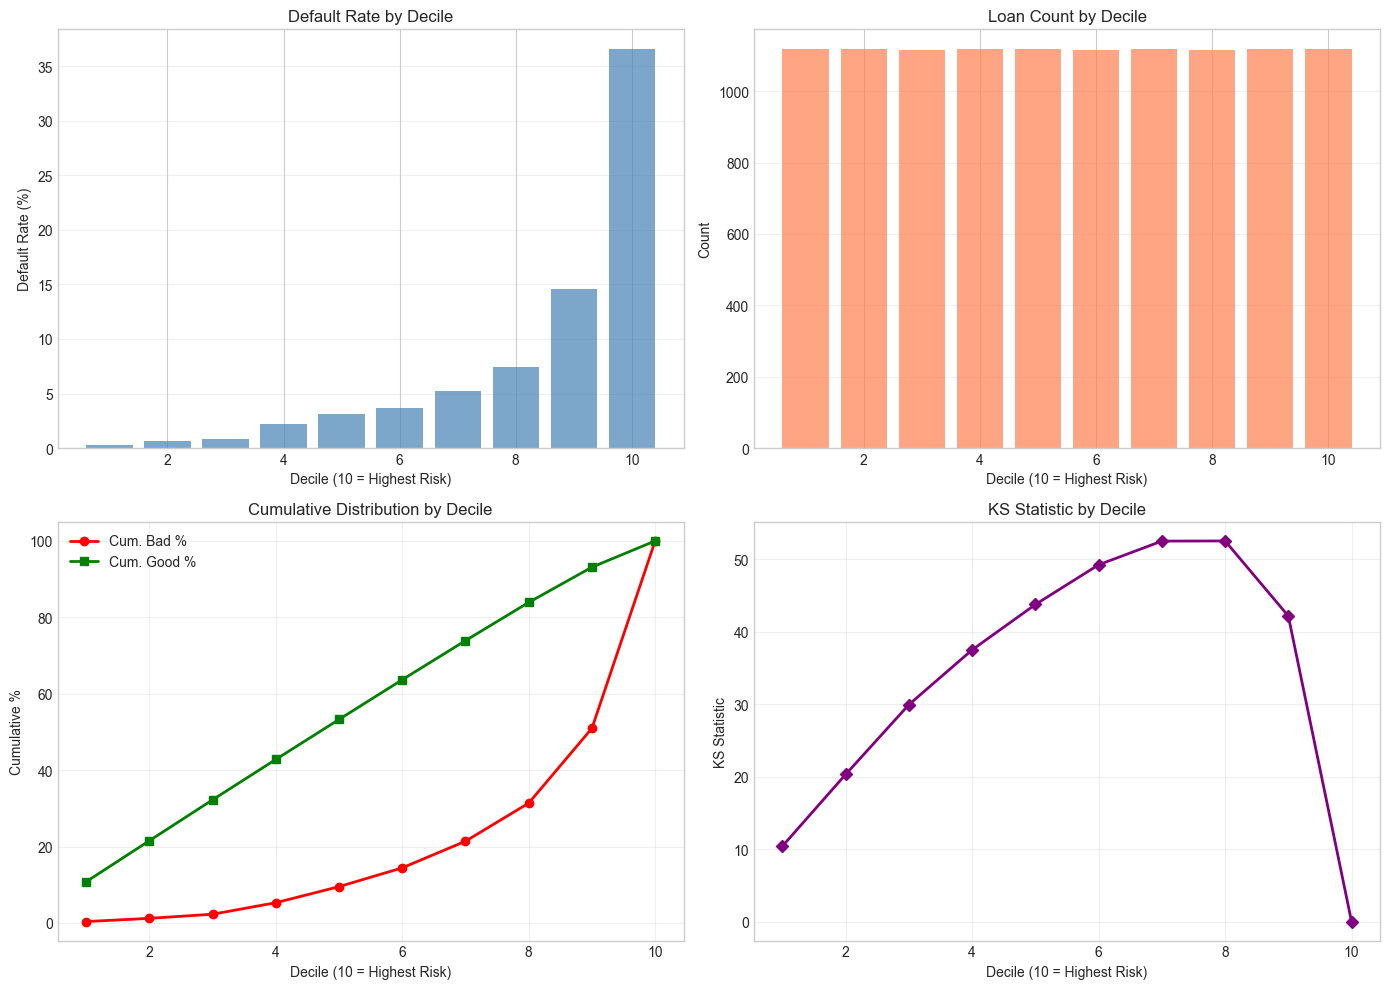

✓ Saved: decile_analysis_plots.png


In [77]:
# Plot Decile Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Bad Rate by Decile
axes[0, 0].bar(decile_table['decile'], decile_table['bad_rate'], color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Decile (10 = Highest Risk)', fontsize=10)
axes[0, 0].set_ylabel('Default Rate (%)', fontsize=10)
axes[0, 0].set_title('Default Rate by Decile', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Count by Decile
axes[0, 1].bar(decile_table['decile'], decile_table['count'], color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Decile (10 = Highest Risk)', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)
axes[0, 1].set_title('Loan Count by Decile', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Cumulative Bad % vs Cumulative Good %
axes[1, 0].plot(decile_table['decile'], decile_table['cum_bad_pct'], marker='o', label='Cum. Bad %', color='red', lw=2)
axes[1, 0].plot(decile_table['decile'], decile_table['cum_good_pct'], marker='s', label='Cum. Good %', color='green', lw=2)
axes[1, 0].set_xlabel('Decile (10 = Highest Risk)', fontsize=10)
axes[1, 0].set_ylabel('Cumulative %', fontsize=10)
axes[1, 0].set_title('Cumulative Distribution by Decile', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. KS by Decile
axes[1, 1].plot(decile_table['decile'], decile_table['ks'], marker='D', color='purple', lw=2)
axes[1, 1].set_xlabel('Decile (10 = Highest Risk)', fontsize=10)
axes[1, 1].set_ylabel('KS Statistic', fontsize=10)
axes[1, 1].set_title('KS Statistic by Decile', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('decile_analysis_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: decile_analysis_plots.png")

## 9. Feature Importance

In [78]:
# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Most Important Features:
              feature  importance
  InitialInterestRate    0.028350
             State_PR    0.023931
      LocationIDCount    0.023678
           ApprovalFY    0.020260
          IsFixedRate    0.019925
     SameStateLending    0.019363
             State_ID    0.018456
             State_MS    0.017660
        GrossApproval    0.017443
             State_LA    0.016502
             State_CA    0.016487
         Age_Existing    0.016243
       RevolverStatus    0.015773
             State_AR    0.015478
             State_FL    0.015401
          Age_Startup    0.015194
          IsFranchise    0.015127
             State_ME    0.014914
             State_TX    0.014906
SBAGuaranteedApproval    0.014890


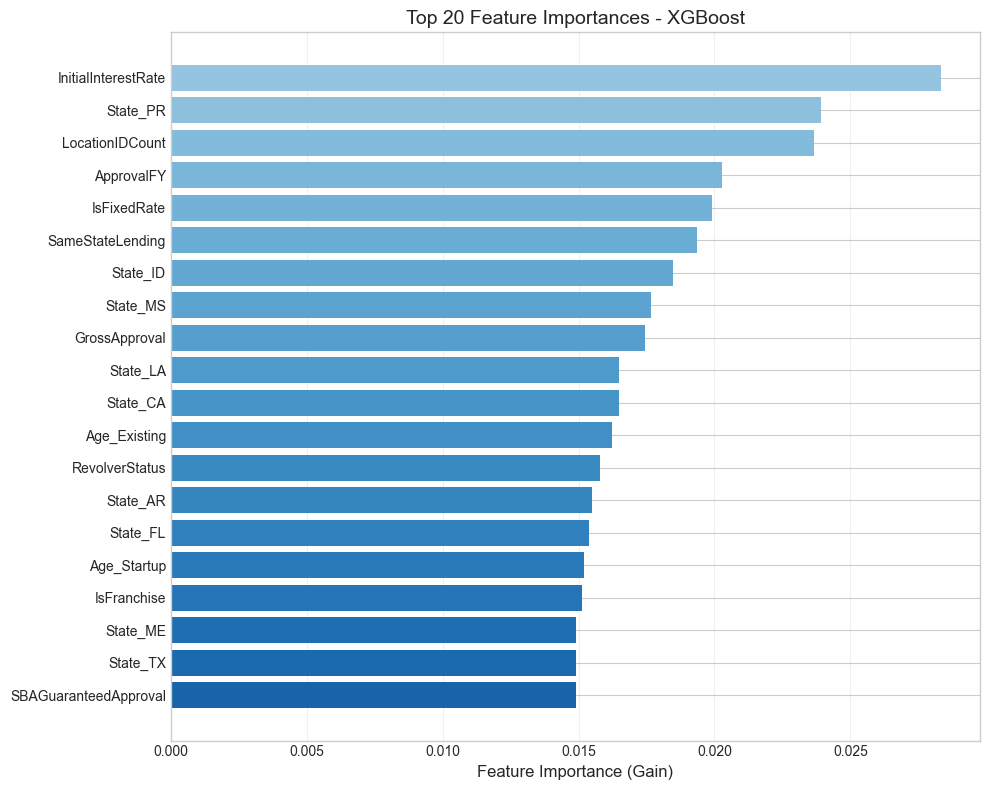

✓ Saved: feature_importance.png


In [79]:
# Plot feature importance (top 20)
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = feature_importance.head(20)
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(top_20)))

bars = ax.barh(range(len(top_20)), top_20['importance'].values, color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
ax.set_title('Top 20 Feature Importances - XGBoost', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
#plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance.png")

## 10. Final Summary

In [80]:
# Final Summary
print("\n" + "="*60)
print("✓ MODEL TRAINING COMPLETE")
print("="*60)
print(f"\nBest Model: XGBoost (Optuna tuned)")
print(f"\nFinal Metrics on Test Set:")
print(f"  • ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
print(f"  • Average Precision: {average_precision_score(y_test, y_prob_best):.4f}")
print(f"  • F1 Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"  • KS Statistic: {ks_stat:.4f}")
print(f"\nSaved Files:")
print(f"  • model_evaluation_curves.png")
print(f"  • confusion_matrix.png")
print(f"  • ks_curve.png")
print(f"  • decile_analysis.csv")
print(f"  • decile_analysis_plots.png")
print(f"  • feature_importance.png")


✓ MODEL TRAINING COMPLETE

Best Model: XGBoost (Optuna tuned)

Final Metrics on Test Set:
  • ROC-AUC: 0.8463
  • Average Precision: 0.3708
  • F1 Score: 0.3901
  • Precision: 0.2767
  • Recall: 0.6611
  • KS Statistic: 0.5311

Saved Files:
  • model_evaluation_curves.png
  • confusion_matrix.png
  • ks_curve.png
  • decile_analysis.csv
  • decile_analysis_plots.png
  • feature_importance.png
